In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Amazon product co-purchasing network metadata数据集分析

## 数据获取与预处理

### 将txt文件转为csv文件

In [2]:
with open('amazon-meta.txt') as f:
    data = f.readlines()
data = [x.strip() for x in data]

target_file = open('amazon_preprocessed.txt', 'w', encoding = 'utf-8')
all_row = ['Id', 'title', 'group', 'salesrank', 'categories', 'totalreviews', 'avgrating']

for line in data:
    lines = line.split(':')
    if lines[0] == 'Id':
        if len(all_row) == 7:
            for comp in all_row[:6]:
                target_file.write(comp)
                target_file.write(',')

            target_file.write(all_row[6])
            target_file.write('\n')
            all_row = []
            all_row.append(lines[1].strip())
    if lines[0] == 'title':
        title = ':'.join(lines[1:]).strip().replace(',', ' ').replace('\n', ' ').strip()
        all_row.append(title)
    if lines[0] == 'group' or lines[0] == 'salesrank' or lines[0] == 'categories':
        all_row.append(lines[1].strip())
    elif lines[0] == 'reviews' and lines[1].strip() == 'total':
        all_row.append(lines[2].split(' ')[1])
        all_row.append(lines[4].strip())

target_file.close()

meta = pd.read_csv('amazon_preprocessed.txt', sep = ',')
meta['Id'].iloc[0] = 1
meta.to_csv('amazon_meta.csv', index = False)
    

C:\Users\26919\AppData\Local\Temp\ipykernel_14880\198171986.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['Id'].iloc[0] = 1


In [26]:
df = pd.read_csv('amazon_meta.csv')
print(df.head(5))
print(df.dtypes)

   Id                                              title group  salesrank  \
0   1            Patterns of Preaching: A Sermon Sampler  Book     396585   
1   2                         Candlemas: Feast of Flames  Book     168596   
2   3   World War II Allied Fighter Planes Trading Cards  Book    1270652   
3   4  Life Application Bible Commentary: 1 and 2 Tim...  Book     631289   
4   5    Prayers That Avail Much for Business: Executive  Book     455160   

   categories  totalreviews  avgrating  
0           2             2        5.0  
1           2            12        4.5  
2           1             1        5.0  
3           5             1        4.0  
4           2             0        0.0  
Id                int64
title            object
group            object
salesrank         int64
categories        int64
totalreviews      int64
avgrating       float64
dtype: object


### 对数据进行一系列探索性分析

In [27]:
#检查缺失值
print(df.isnull().any())
#删除重复数据
print(f'原始长度：{len(df)}')
df_nodup = df.drop_duplicates()
print(f'去重后长度：{len(df_nodup)}')

numeric = ['salesrank', 'categories', 'totalreviews', 'avgrating']
print(df[numeric].describe().loc[['max', '75%', '50%', '25%', 'min']])

Id              False
title           False
group           False
salesrank       False
categories      False
totalreviews    False
avgrating       False
dtype: bool
原始长度：542683
去重后长度：542683
     salesrank  categories  totalreviews  avgrating
max  3798351.0       116.0        5545.0        5.0
75%   672069.5         6.0           8.0        5.0
50%   300493.0         4.0           2.0        4.0
25%    90744.0         2.0           0.0        0.0
min       -1.0         0.0           0.0        0.0


In [28]:
def hist_plot(data, features):
    for col in features:
        data[col].hist(bins = 8, histtype = 'bar')
        plt.title(f'Distribution of {col}')
        plt.show()

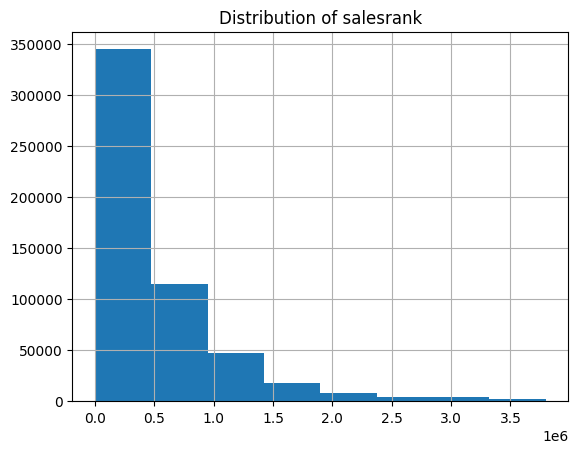

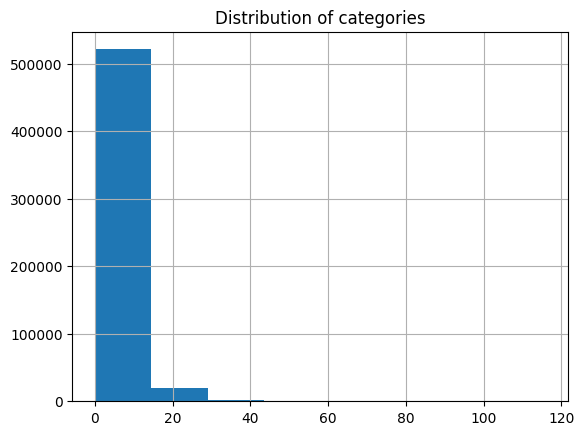

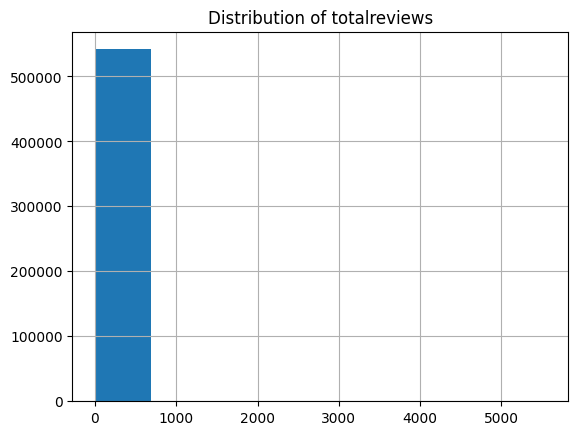

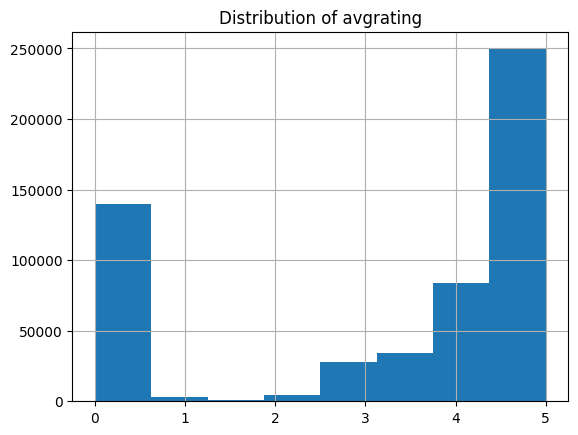

In [29]:
hist_plot(df, numeric)

In [30]:
def bar_plot(data, features):
    for col in features:
        v = list(data[col].value_counts().values)
        id = list(data[col].value_counts().index)

        bar = plt.barh(id[:20], v[:20])
        plt.yticks(rotation = 45, size = 7)
        plt.xticks(rotation = 45, size = 7)
        plt.bar_label(bar, v[:20])
        plt.show()

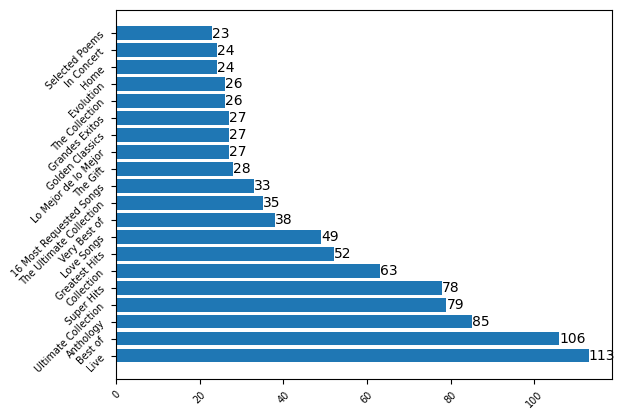

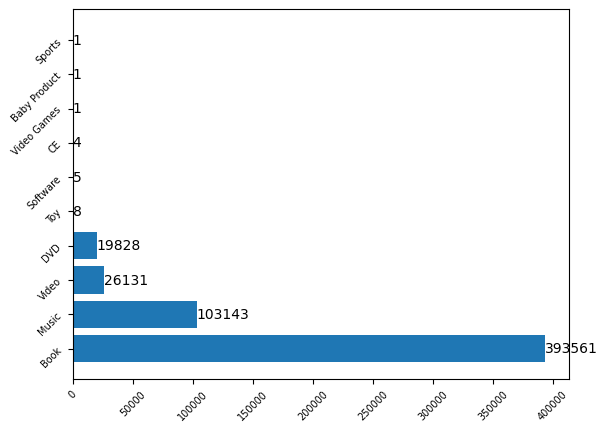

In [31]:
bar_plot(df, ['title', 'group'])

### 为方便挖掘关联规则，将数值型属性根据数值划分范围

In [32]:
def trans_avg(row):
    if 0 <= row['avgrating'] < 1:
        new = '[0,1)'
    elif 1 <= row['avgrating'] < 2:
        new = '[1,2)'
    elif 2 <= row['avgrating'] < 3:
        new = '[2,3)'
    elif 3 <= row['avgrating'] < 4:
        new = '[3,4)'
    elif 4 <= row['avgrating']:
        new = '[4,5]'
    return new

def trans_reviews(row):
    if 0 <= row['totalreviews'] < 5:
        new = '[0,5)'
    elif 5 <= row['totalreviews'] < 10:
        new = '[5,10)'
    elif 10 <= row['totalreviews'] < 1000:
        new = '[10,1000)'
    elif 1000 <= row['totalreviews'] < 3000:
        new = '[1000,3000)'
    elif 3000 <= row['totalreviews']:
        new = '[3000,-)'
    return new

def trans_categories(row):
    if 0 <= row['categories'] < 2:
        new = '[0,2)'
    elif 2 <= row['categories'] < 5:
        new = '[2,5)'
    elif 5 <= row['categories'] < 10:
        new = '[5,10)'
    elif 10 <= row['categories'] < 50:
        new = '[10,50)'
    elif 50 <= row['categories']:
        new = '[50,-)'
    return new

def trans_salesrank(row):
    if row['salesrank'] < 500000:
        new = '[-,500000)'
    elif 500000 <= row['salesrank'] < 1000000:
        new = '[500000,1000000)'
    elif 1000000 <= row['salesrank'] < 1500000:
        new = '[1000000,1500000)'
    elif 1500000 <= row['salesrank'] < 2000000:
        new = '[1500000,2000000)'
    elif 2000000 <= row['salesrank']:
        new = '[2000000,-)'
    return new

In [33]:
new_rating = []
new_reviews = []
new_rank = []
new_cat = []
for i, row in df.iterrows():
    new_rating.append(trans_avg(row))
    new_reviews.append(trans_reviews(row))
    new_rank.append(trans_salesrank(row))
    new_cat.append(trans_categories(row))
df['avgrating'] = new_rating
df['totalreviews'] = new_reviews
df['categories'] = new_cat
df['salesrank'] = new_rank
df.head(5)

,Id,title,group,salesrank,categories,totalreviews,avgrating
0,1,Patterns of Preaching: A Sermon Sampler,Book,"[-,500000)","[2,5)","[0,5)","[4,5]"
1,2,Candlemas: Feast of Flames,Book,"[-,500000)","[2,5)","[10,1000)","[4,5]"
2,3,World War II Allied Fighter Planes Trading Cards,Book,"[1000000,1500000)","[0,2)","[0,5)","[4,5]"
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,"[500000,1000000)","[5,10)","[0,5)","[4,5]"
4,5,Prayers That Avail Much for Business: Executive,Book,"[-,500000)","[2,5)","[0,5)","[0,1)"


### 将数据中的group、salesrank、categories、totalreviews和avgrating提取出来为子数据集并转化为list

In [34]:
data = df[['avgrating', 'totalreviews', 'categories', 'salesrank', 'group']]
print(data.head(5))
arr = np.array(data)
d = arr.tolist()

  avgrating totalreviews categories          salesrank group
0     [4,5]        [0,5)      [2,5)         [-,500000)  Book
1     [4,5]    [10,1000)      [2,5)         [-,500000)  Book
2     [4,5]        [0,5)      [0,2)  [1000000,1500000)  Book
3     [4,5]        [0,5)     [5,10)   [500000,1000000)  Book
4     [0,1)        [0,5)      [2,5)         [-,500000)  Book


## 频繁模式挖掘

In [36]:
pip install apyori

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5975 sha256=ba8d3e74c7926b3c14b778f79f9a8b20c2178e1ac07ec5eace471e539e6d28a1
  Stored in directory: c:\users\26919\appdata\local\pip\cache\wheels\84\45\a4\8ade6576f75410d8162c6da1de0aa9df56c16c711acab5a813
Successfully built apyori
Note: you may need to restart the kernel to use updated packages.


In [12]:
from apyori import apriori

In [38]:
result = list(apriori(transactions = d, min_support = 0.1, min_confidence = 0.5))

In [14]:
def show_result(result):
    lastitems = []
    for i in result:
        tempitem = ':'.join(i.items)
        sup = round(i.support, 4)
        for j in i.ordered_statistics:
            col = []
            tempitembase = ':'.join(j.items_base)
            tempitemadd = ':'.join(j.items_add)
            col.append(tempitem)
            col.append(sup)
            col.append(tempitembase)
            col.append(tempitemadd)
            col.append(round(j.confidence, 4))
            col.append(round(j.lift, 2))
            lastitems.append(col)
    lastitems = pd.DataFrame(lastitems)
    lastitems.columns = ['LastItem', 'Support', 'ItemBase', 'ItemAdd', 'Confidence', 'Lift']
    lastitems.index = range(len(lastitems))
    print(len(lastitems))
    lastitems = lastitems.sort_values('Confidence', ascending = False).reset_index()
    print(lastitems.head(10))

    return lastitems

In [40]:
lastitems = show_result(result)

128
   index                     LastItem  Support                ItemBase  \
0     54             [0,5):[0,1):Book   0.2125              [0,1):Book   
1    101            [0,5):[2,5):[0,1)   0.1197             [2,5):[0,1)   
2     28                  [0,5):[0,1)   0.2579                   [0,1)   
3     86       [0,5):[0,1):[-,500000)   0.1005        [0,1):[-,500000)   
4    119       [0,5):[2,5):[0,1):Book   0.1037        [2,5):[0,1):Book   
5     85       [-,500000):Music:[4,5]   0.1375             Music:[4,5]   
6     79  [500000,1000000):[4,5]:Book   0.1086  [500000,1000000):[4,5]   
7     74  [2,5):[500000,1000000):Book   0.1131  [2,5):[500000,1000000)   
8     17        [500000,1000000):Book   0.2020        [500000,1000000)   
9     18             [-,500000):Music   0.1845                   Music   

      ItemAdd  Confidence  Lift  
0       [0,5)      1.0000  1.55  
1       [0,5)      1.0000  1.55  
2       [0,5)      1.0000  1.55  
3       [0,5)      1.0000  1.55  
4       [0,

## 模式命名与分析

#### 分析：以index为18的数据为例，存在“Music->[-,500000)”，即“音乐类别的产品->销售排名高于500000”，可以得出，音乐类别的产品的销售排名约有97%的概率高于500000，且这种情况的发生比例约为18.35%，其余数据同理可进行解释。

##### 模式命名：产品销售模式

## 可视化

In [15]:
def scatter(items, size):
    items.plot(kind = 'scatter', x = 'Support', c = 'r', y = 'Confidence', s = size, figsize = (8, 5))
    plt.grid('on')
    plt.xlabel('Support', size = 12)
    plt.ylabel('Confidence', size = 12)
    plt.title(f'Scatter plot of {size} rules')
    plt.show()

In [16]:
import networkx as nx

In [17]:
def network(items, size):
    plt.figure(figsize = (8, 8))
    #生成社交网络图
    G = nx.DiGraph()

    draw_df = items[0: size]

    #为图像添加边
    for ii in draw_df.index:
        G.add_edge(draw_df.ItemBase[ii], draw_df.ItemAdd[ii], weight = draw_df.Confidence[ii])

    #定义两种边
    elarge = [(u,v) for (u,v,d) in G.edges(data = True) if d['weight'] > 0.6]
    emidle = [(u,v) for (u,v,d) in G.edges(data = True) if (d['weight'] <= 0.6) and (d['weight'] > 0.45)]
    esmall = [(u,v) for (u,v,d) in G.edges(data = True) if d['weight'] <= 0.45]

    #图的布局方式
    pos = nx.circular_layout(G)

    #根据规则的置信度节点的大小
    nx.draw_networkx_nodes(G, pos, alpha = 0.4)

    #设置边的形式
    nx.draw_networkx_edges(G, pos, edgelist = elarge, width = 2, alpha = 0.6, edge_color = 'r')
    nx.draw_networkx_edges(G, pos, edgelist = emidle, width = 2, alpha = 0.6, edge_color = 'g', style = 'dashdot')
    nx.draw_networkx_edges(G, pos, edgelist = esmall, width = 2, alpha = 0.6, edge_color = 'b', style = 'dashed')

    #为节点添加标签
    nx.draw_networkx_labels(G, pos, font_size = 10)

    plt.axis('off')
    plt.title(f'Sample network of {size} rules')
    plt.show()

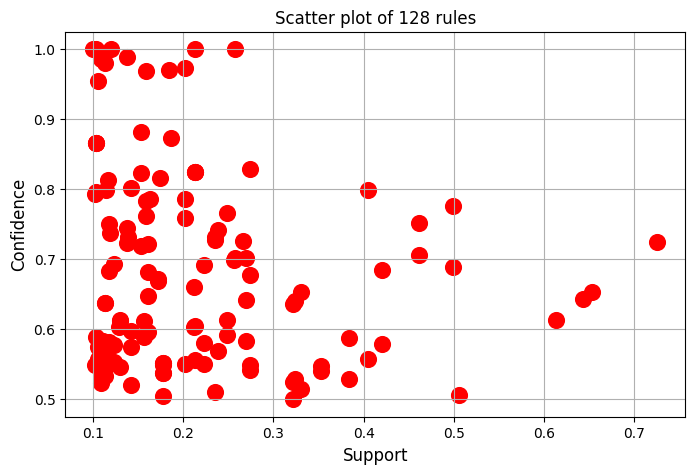

In [44]:
scatter(lastitems, 128)

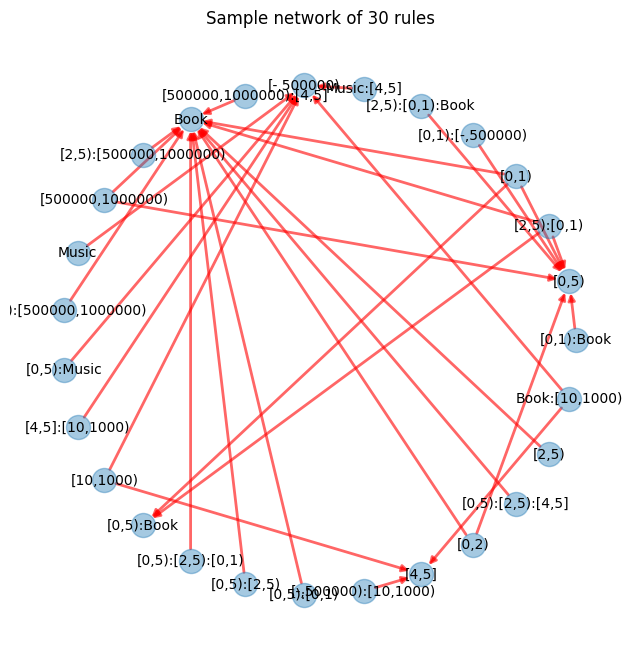

In [45]:
network(lastitems, 30)

# Mooc User Action Dataset数据集

## 数据获取与预处理

In [4]:
path = 'act-mooc/'
actions = pd.read_csv(path + 'mooc_actions.tsv', sep = '\t')
features = pd.read_csv(path + 'mooc_action_features.tsv', sep = '\t')
labels = pd.read_csv(path + 'mooc_action_labels.tsv', sep = '\t')
print(actions.head(5))
print(features.head(5))
print(labels.head(5))

   ACTIONID  USERID  TARGETID  TIMESTAMP
0         0       0         0        0.0
1         1       0         1        6.0
2         2       0         2       41.0
3         3       0         1       49.0
4         4       0         2       51.0
   ACTIONID  FEATURE0  FEATURE1  FEATURE2  FEATURE3
0         0 -0.319991 -0.435701  0.106784 -0.067309
1         1 -0.319991 -0.435701  0.106784 -0.067309
2         2 -0.319991 -0.435701  0.106784 -0.067309
3         3 -0.319991 -0.435701  0.106784 -0.067309
4         4 -0.319991 -0.435701  0.106784 -0.067309
   ACTIONID  LABEL
0         0      0
1         1      0
2         2      0
3         3      0
4         4      0


In [5]:
#将三个表合并
act = pd.merge(actions, features, on = 'ACTIONID')
act = pd.merge(act, labels, on = 'ACTIONID')
print(act.head(5))
print(act.dtypes)

   ACTIONID  USERID  TARGETID  TIMESTAMP  FEATURE0  FEATURE1  FEATURE2  \
0         0       0         0        0.0 -0.319991 -0.435701  0.106784   
1         1       0         1        6.0 -0.319991 -0.435701  0.106784   
2         2       0         2       41.0 -0.319991 -0.435701  0.106784   
3         3       0         1       49.0 -0.319991 -0.435701  0.106784   
4         4       0         2       51.0 -0.319991 -0.435701  0.106784   

   FEATURE3  LABEL  
0 -0.067309      0  
1 -0.067309      0  
2 -0.067309      0  
3 -0.067309      0  
4 -0.067309      0  
ACTIONID       int64
USERID         int64
TARGETID       int64
TIMESTAMP    float64
FEATURE0     float64
FEATURE1     float64
FEATURE2     float64
FEATURE3     float64
LABEL          int64
dtype: object


## 将TIMESTAMP, ACTIONID, TARGETID, FEATUREx, LABEL转化为适用于频繁项集与关联规则挖掘的格式

In [6]:
def trans_timestamp(row):
    if row['TIMESTAMP'] < 500000:
        new = '[-,500000)'
    elif 500000 <= row['TIMESTAMP'] < 1000000:
        new = '[500000,1000000)'
    elif 1000000 <= row['TIMESTAMP'] < 1500000:
        new = '[1000000,1500000)'
    elif 1500000 <= row['TIMESTAMP'] < 2000000:
        new = '[1500000,2000000)'
    elif 2000000 <= row['TIMESTAMP']:
        new = '[2000000,-)'
    return new

In [8]:
new = []
for i, row in act.iterrows():
    new.append(trans_timestamp(row))
act['TIMESTAMP'] = new

#将属性值转化为字符串
act['ACTIONID'] = act['ACTIONID'].astype('string')
act['TARGETID'] = act['TARGETID'].astype('string')
act['LABEL'] = act['LABEL'].astype('string')
act['FEATURE0'] = act['FEATURE0'].astype('string')
act['FEATURE1'] = act['FEATURE1'].astype('string')
act['FEATURE2'] = act['FEATURE2'].astype('string')
act['FEATURE3'] = act['FEATURE3'].astype('string')
act['USERID'] = act['USERID'].astype('string')
print(act.dtypes)

ACTIONID     string[python]
USERID       string[python]
TARGETID     string[python]
TIMESTAMP            object
FEATURE0     string[python]
FEATURE1     string[python]
FEATURE2     string[python]
FEATURE3     string[python]
LABEL        string[python]
dtype: object


In [9]:
#将FEATURE0、FEATURE1、FEATURE2和FEATURE3合并
act['FEATURES'] = act['FEATURE0'] + ',' + act['FEATURE1'] + ',' + act['FEATURE2'] + ',' + act['FEATURE3']
act['NEW_TARGETID'] = 'TARGETID_' + act['TARGETID']
act['NEW_ACTIONID'] = 'ACTIONID_' + act['ACTIONID']
act['NEW_LABEL'] = 'LABEL_' + act['LABEL']
print(act.head(5))

  ACTIONID USERID TARGETID   TIMESTAMP             FEATURE0  \
0        0      0        0  [-,500000)  -0.3199914794575269   
1        1      0        1  [-,500000)  -0.3199914794575269   
2        2      0        2  [-,500000)  -0.3199914794575269   
3        3      0        1  [-,500000)  -0.3199914794575269   
4        4      0        2  [-,500000)  -0.3199914794575269   

              FEATURE1          FEATURE2             FEATURE3 LABEL  \
0  -0.4357014334929225  0.10678377884769  -0.0673092397645177     0   
1  -0.4357014334929225  0.10678377884769  -0.0673092397645177     0   
2  -0.4357014334929225  0.10678377884769  -0.0673092397645177     0   
3  -0.4357014334929225  0.10678377884769  -0.0673092397645177     0   
4  -0.4357014334929225  0.10678377884769  -0.0673092397645177     0   

                                            FEATURES NEW_TARGETID  \
0  -0.3199914794575269,-0.4357014334929225,0.1067...   TARGETID_0   
1  -0.3199914794575269,-0.4357014334929225,0.1067...   T

In [10]:
#将数据按LABEL划分
label_group = act.groupby('NEW_LABEL')
g0 = label_group.get_group("LABEL_0")
print(g0)
g1 = label_group.get_group("LABEL_1")
print(g1)

       ACTIONID USERID TARGETID    TIMESTAMP             FEATURE0  \
0             0      0        0   [-,500000)  -0.3199914794575269   
1             1      0        1   [-,500000)  -0.3199914794575269   
2             2      0        2   [-,500000)  -0.3199914794575269   
3             3      0        1   [-,500000)  -0.3199914794575269   
4             4      0        2   [-,500000)  -0.3199914794575269   
...         ...    ...      ...          ...                  ...   
411744   411744   7026        8  [2000000,-)  -0.3199914794575269   
411745   411745   6842        8  [2000000,-)  -0.3199914794575269   
411746   411746   7026        9  [2000000,-)  -0.3199914794575269   
411747   411747   6842        5  [2000000,-)  -0.3199914794575269   
411748   411748     70       23  [2000000,-)  -0.3199914794575269   

                   FEATURE1          FEATURE2             FEATURE3 LABEL  \
0       -0.4357014334929225  0.10678377884769  -0.0673092397645177     0   
1       -0.43570143

In [11]:
g0 = g0[['NEW_ACTIONID', 'NEW_TARGETID', 'TIMESTAMP']]
g1 = g1[['NEW_ACTIONID', 'NEW_TARGETID', 'TIMESTAMP']]
arr0 = np.array(g0)
arr1 = np.array(g1)
d0 = arr0.tolist()
d1 = arr1.tolist()

## 频繁模式挖掘

In [13]:
result2 = list(apriori(transactions = d1, min_support = 0.01, min_confidence = 0.2))

In [18]:
lastitems2 = show_result(result2)

12
   index                      LastItem  Support     ItemBase  \
0     10         [-,500000):TARGETID_9   0.0239   TARGETID_9   
1      2        [-,500000):TARGETID_13   0.0332  TARGETID_13   
2      4        [-,500000):TARGETID_15   0.0251  TARGETID_15   
3      6        [-,500000):TARGETID_16   0.0248  TARGETID_16   
4     11   TARGETID_9:[500000,1000000)   0.0167   TARGETID_9   
5      8         [-,500000):TARGETID_8   0.0162   TARGETID_8   
6      7  TARGETID_16:[500000,1000000)   0.0224  TARGETID_16   
7      5  TARGETID_15:[500000,1000000)   0.0184  TARGETID_15   
8      9   TARGETID_8:[500000,1000000)   0.0145   TARGETID_8   
9      0                   [2000000,-)   0.2415                

            ItemAdd  Confidence  Lift  
0        [-,500000)      0.4093  2.26  
1        [-,500000)      0.3750  2.07  
2        [-,500000)      0.3423  1.89  
3        [-,500000)      0.2919  1.61  
4  [500000,1000000)      0.2869  1.37  
5        [-,500000)      0.2705  1.49  
6  [500000,1

In [19]:
result20 = list(apriori(transactions = d0, min_support = 0.01, min_confidence = 0.2))

In [20]:
lastitems20 = show_result(result20)

15
   index                       LastItem  Support     ItemBase  \
0     11        [2000000,-):TARGETID_79   0.0104  TARGETID_79   
1      2          [-,500000):TARGETID_1   0.0149   TARGETID_1   
2      5        [2000000,-):TARGETID_21   0.0176  TARGETID_21   
3      6          TARGETID_3:[-,500000)   0.0148   TARGETID_3   
4      3         [-,500000):TARGETID_14   0.0140  TARGETID_14   
5      8          TARGETID_5:[-,500000)   0.0112   TARGETID_5   
6      7          [-,500000):TARGETID_4   0.0112   TARGETID_4   
7     14          [-,500000):TARGETID_9   0.0136   TARGETID_9   
8      4  [1500000,2000000):TARGETID_21   0.0139  TARGETID_21   
9      9          [-,500000):TARGETID_7   0.0129   TARGETID_7   

             ItemAdd  Confidence  Lift  
0        [2000000,-)      0.8278  3.20  
1         [-,500000)      0.4724  2.84  
2        [2000000,-)      0.4507  1.74  
3         [-,500000)      0.4267  2.56  
4         [-,500000)      0.4243  2.55  
5         [-,500000)      0.4087  2

## 模式命名与分析

a.LABEL = 1 \
根据结果可以发现，存在“TIMESTAMP[-,500000]->TARGETID_8,9,13,15,16”，即“在500000的时间节点前->目标网页为8,9,16,15,16”，其中有40.93%的概率在时间点500000前，用户的目标网页为9，其余可进行同理解释。 \
a.LABEL = 0 \
根据结果可以发现，存在“TIMESTAMP[-,500000]->TARGETID_1,3,4,5,7,9,14”，即“在500000的时间节点前->目标网页为1,3,4,5,7,9,14”，其中有47.24%的概率在时间点500000前，用户的目标网页为1，其余可进行同理解释。 \

模式命名： \
根据分析，我们可以得知不同时间点用户的目标网页不同，即存在“时间偏好”关系模式

## 可视化

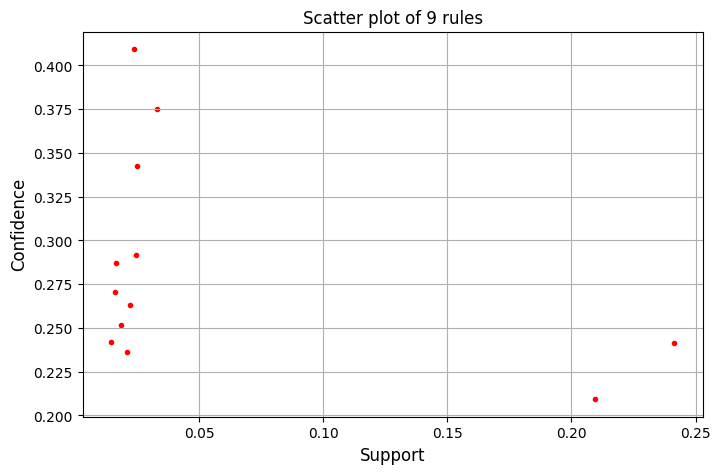

In [21]:
scatter(lastitems2, 9)

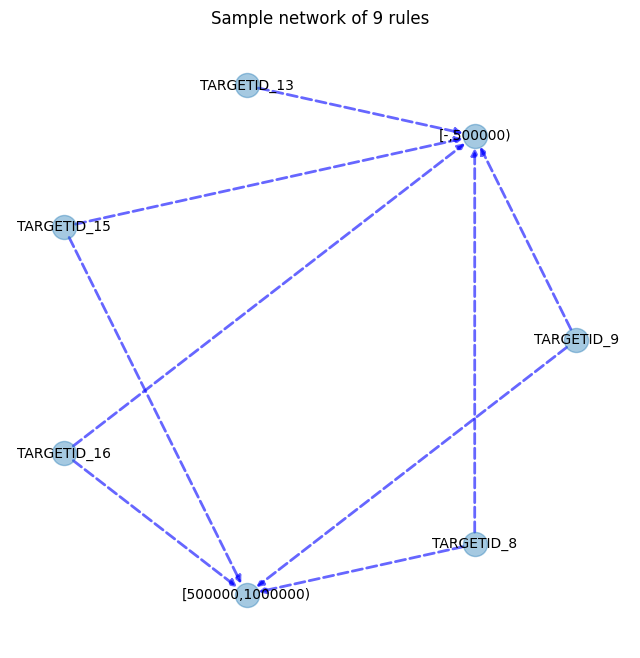

In [22]:
network(lastitems2, 9)

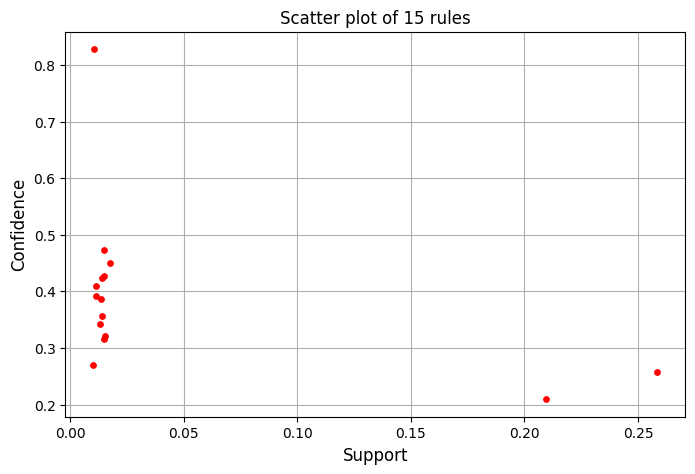

In [23]:
scatter(lastitems20, 15)

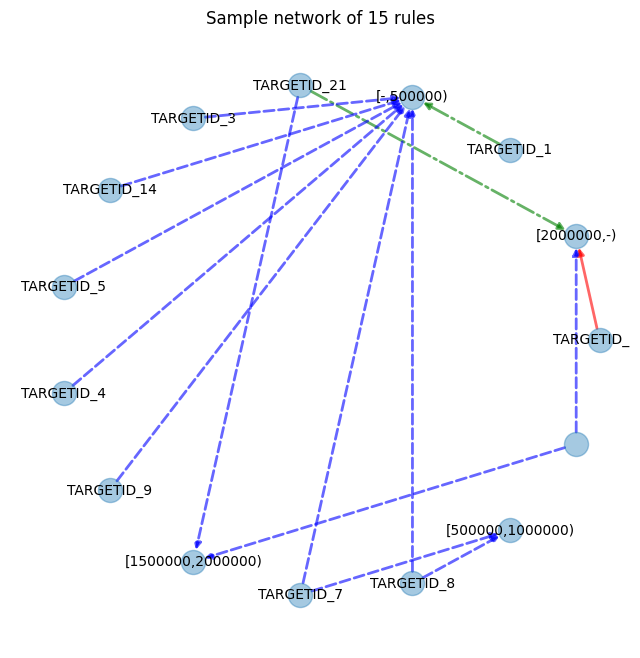

In [24]:
network(lastitems20, 15)